In [2]:
%pylab
%matplotlib inline

from typing import Callable, List, Tuple, Union
import warnings
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from scipy.stats import norm, truncnorm
from scipy.special import factorial

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [30]:
# reference point
r = np.array([6, 6])

# Pareto-front approximation set
pf = np.array([[3, 4], [1, 5], [5, 1]])

mu = np.array([2, 3])    # mean of f1 and f2
ss = np.array([0.5, 1])  # std.
L1, L2, U1, U2 = 0.5, 0.3, 5, 7

In [31]:
from numba import cfunc, jit, carray, prange
from numba.types import CPointer, float64, intc
from scipy import LowLevelCallable

def jit_integrand(integrand_function):
    jitted_function = jit(integrand_function, nopython=True, error_model="numpy")

    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values)

    return LowLevelCallable(wrapped.ctypes)

@jit_integrand
def integrand_eq4(args):
    x, mu0, mu1, sigma0, sigma1, p = args
    out = np.exp(-0.5 * (((x - mu0) / sigma0) ** 2 + ((p / x - mu1) / sigma1) ** 2)) / x
    return out

In [37]:
def D(L, U, loc, scale):
    out = norm.cdf(U, loc, scale) - norm.cdf(L, loc, scale)
    if out == 0:
        val = np.mean(
            norm.pdf(np.linspace(L, U, 10), loc=loc, scale=scale)
            / truncnorm.pdf(
                np.linspace(L, U, 10), (L - loc) / scale, (U - loc) / scale, loc=loc, scale=scale
            )
        )
        if not np.isnan(val):
            out = val
    return out

def pdf_product_of_truncated_gaussian(
    p: float,
    mean: List[float],
    sigma: List[float],
    lower: List[float],
    upper: List[float],
    normalizer: float
) -> float:
    if normalizer == 0:
        return 0
    
    normalizer *= 2 * np.pi * np.prod(sigma)
    (L1, L2), (U1, U2) = lower, upper
    
    if L1 * U2 > U1 * L2:  # swap y_1' and y_2'
        (L2, L1), (U2, U1) = lower, upper
        mean = mean[1], mean[0]
        sigma = sigma[1], sigma[0]

    if L1 * L2 <= p < L1 * U2:
        alpha = L1
        beta = p / L2
    elif L1 * U2 <= p < U1 * L2:
        alpha = p / U2
        beta = p / L2
    elif U1 * L2 <= p <= U1 * U2:
        alpha = p / U2
        beta = U1
    else:
        return 0

    if alpha == beta:
        return 0
    
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try:
            if alpha <= 0 <= beta:
                out = (
                    quad(
                        integrand_eq4,
                        alpha,
                        -1 * sys.float_info.min,
                        args=(mean[0], mean[1], sigma[0], sigma[1], p),
                    )[0]
                    + quad(
                        integrand_eq4,
                        sys.float_info.min,
                        beta,
                        args=(mean[0], mean[1], sigma[0], sigma[1], p),
                    )[0]
                )
            else:
                out = quad(
                    integrand_eq4,
                    alpha,
                    beta,
                    args=(mean[0], mean[1], sigma[0], sigma[1], p),
                )[0]
        except Warning:
            out = 0
            
    return out / normalizer

In [38]:
pvals = np.clip(10 ** np.linspace(np.log10(L1 * L2), np.log10(U1 * U2), 200), L1 * L2, U1 * U2)
lower, upper = [L1, L2], [U1, U2]
normalizer = np.prod([D(lower[k], upper[k], mu[k], ss[k]) for k in range(len(ss))])
rst_new = [pdf_product_of_truncated_gaussian(p, mu, ss, [L1, L2], [U1, U2], normalizer) for p in pvals]

In [34]:
from scipy.stats import norm

def rcond_norm(N, loc, scale, L=1, U=2):
#     alpha = norm.cdf(L, loc, scale)
#     beta = norm.cdf(U, loc, scale)
#     Z = beta - alpha 
#     return norm.ppf(np.random.rand(int(N)) * Z + alpha, loc, scale)
    return truncnorm.rvs((L - loc) / scale, (U - loc) / scale, loc, scale, int(N))

In [35]:
def sample(mean, sigma, lower, upper, N=1e3):
    return rcond_norm(N, mean[0], sigma[0], lower[0], upper[0]) * rcond_norm(N, mean[1], sigma[1], lower[1], upper[1])

x = rcond_norm(1e7, mu[0], ss[0], L1, U1)
y = rcond_norm(1e7, mu[1], ss[1], L2, U2)

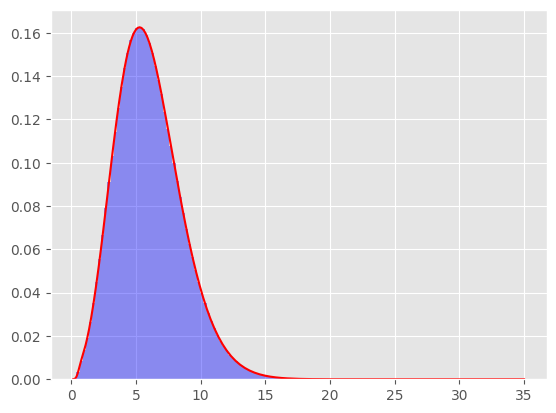

In [39]:
a = x * y
a = a[~np.isinf(a)]
n, bins, patches = plt.hist(a, 100, density=True, facecolor='b', alpha=0.4)
plt.plot(pvals, np.array(rst_new), 'r-')

In [16]:
@jit(nopython=True, error_model="numpy")
def D(L, U, loc, scale):
    out = 0.5 * (1 + erf((U - loc) / scale / np.sqrt(2))) - 0.5 * (1 + erf((L - loc) / scale / np.sqrt(2)))
    return out

In [40]:
def ecdf(s):
    s = np.sort(s)
    def inner(x):
        return np.sum(s <= x) / len(s)
    return inner

def ecdf_from_pdf(a, mu, ss, lower, upper, normalizer):
    return quad(
        pdf_product_of_truncated_gaussian,
        lower[0] * lower[1],
        a,
        args=(mu, ss, lower, upper, normalizer)
    )[0]

In [43]:
@jit(nopython=True, error_model="numpy")
def dnorm(x, mu, sigma):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2) / (np.sqrt(2 * np.pi) * sigma)

@jit(nopython=True, error_model="numpy")
def erf(x: float) -> float:
    p = 0.3275911
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.421413741
    a4 = -1.453152027
    a5 = 1.061405429
    
    x_ = x if x >= 0 else -1.0 * x
    t = 1 / (1 + p * x_)
    out = 1 - (a1 * t + a2 * t ** 2 + a3 * t ** 3 + a4 * t ** 4 + a5 * t ** 5) * np.exp(-1. * x_ ** 2)
    return out if x >=0 else -1.0 * out

@jit_integrand
def integrand_cdf(args):
    x, a, mu0, mu1, sigma0, sigma1, L2 = args
    return 0.5 * (1 + erf((a / x - mu1) / sigma1 / np.sqrt(2))) * dnorm(x, mu0, sigma0)
    
def cdf_product_of_truncated_gaussian(
    p: float,
    mean: List[float],
    sigma: List[float],
    lower: List[float],
    upper: List[float],
    normalizer: float
):
    if normalizer == 0:
        return 0
    
    (L1, L2), (U1, U2) = lower, upper
    if L1 * U2 > U1 * L2:  # swap y_1' and y_2'
        (L2, L1), (U2, U1) = lower, upper
        mean = mean[1], mean[0]
        sigma = sigma[1], sigma[0]
    
    l, u = max(L1, p / U2), min(U1, p / L2)
    term1 = max(D(L1, p / U2, mean[0], sigma[0]), 0) * D(L2, U2, mean[1], sigma[1]) - \
        D(l, u, mean[0], sigma[0]) * 0.5 * (1 + erf((L2 - mean[1]) / sigma[1] / np.sqrt(2)))
    term2 = quad(
        integrand_cdf, 
        l, 
        u, 
        args=(p, mean[0], mean[1], sigma[0], sigma[1], L2)
    )[0]
    return (term1 + term2) / normalizer

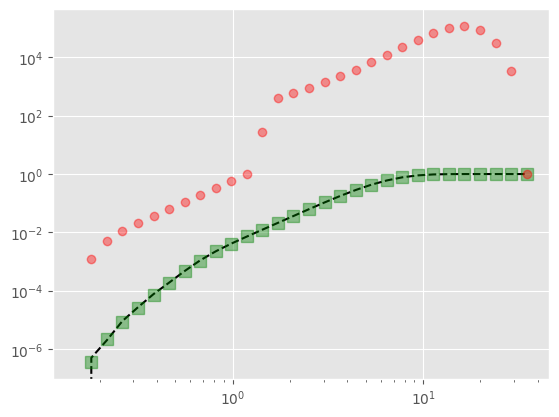

In [44]:
pvals = np.clip(10 ** np.linspace(np.log10(L1 * L2), np.log10(U1 * U2), 30), L1 * L2,  U1 * U2)

lower, upper = [L1, L2], [U1, U2]
normalizer = np.prod([D(lower[k], upper[k], mu[k], ss[k]) for k in range(len(ss))])

f = ecdf(x * y)
v = [f(_) for _ in pvals]
v1 = [ecdf_from_pdf(a, mu, ss, [L1, L2], [U1, U2], normalizer) for a in pvals]
v2 = [cdf_product_of_truncated_gaussian(a, mu, ss, [L1, L2], [U1, U2], normalizer) for a in pvals]

plt.plot(pvals, v, 'k--')
plt.plot(pvals, v1, 'gs', alpha=0.4, ms=8)
plt.plot(pvals, v2, 'ro', alpha=0.4)
plt.xscale('log')
plt.yscale('log')

In [347]:
%timeit -n 5 -r 5 [cdf_product_of_truncated_gaussian(a, mu, ss, [L1, L2], [U1, U2], normalizer) for a in pvals]

1.03 ms ± 241 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [346]:
%timeit -n 5 -r 5 [ecdf_from_pdf(a, mu, ss, [L1, L2], [U1, U2], normalizer) for a in pvals]

87.3 ms ± 943 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [228]:
np.array(v1) - np.array(v2)

array([ 0.00000000e+00,  1.26145043e-23,  2.81241408e-23,  1.52201233e-22,
        2.51462906e-22, -6.53803556e-21, -5.31968455e-18, -1.57961883e-15,
        5.68223582e-17, -8.95359565e-16, -2.10503273e-15, -2.97938757e-16,
       -2.37608327e-15, -1.63536719e-14, -1.17874460e-15, -1.03337477e-14,
       -4.83179729e-12,  6.58708504e-12, -2.99188105e-12, -6.13389201e-12,
       -3.87745391e-14,  9.19903043e-12, -4.29689617e-12,  2.09543494e-12,
        6.86539714e-12, -4.44311254e-13, -5.62849767e-12,  6.12043749e-12,
       -2.43161047e-12, -4.66859884e-12])

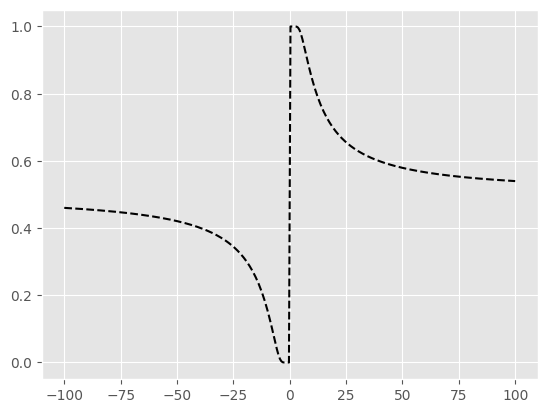

In [10]:
a = 10
x = np.linspace(-100, 100, 300)
y = [norm.cdf(a / _) for _ in x]
plt.plot(x, y, 'k--')

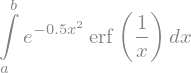

In [49]:
from sympy import *
init_printing(use_unicode=False, wrap_line=False, no_global=True)
x = Symbol('x')
z = Symbol('z')
a = Symbol('a')
b = Symbol('b')

integrate(erf(1 / x) * exp(-0.5 * x ** 2), (x, a, b))